# Titanic survival using scikit-learn `Pipelines` and `LightGBM`

In this notebook you will be introduced to `scikit-learn` best practices using `Pipelines` and how you can easily incorporate a SOTA gradient boosting tree model: `LightGBM`. We will be using a simplified version of the famous [titanic](https://www.kaggle.com/c/titanic) survival dataset to keep the focus on the library/model learnings.

We will cover the following topics:
1. Data loading and inspection
2. Introduction of the preprocessing `pipeline`
3. Incorporate a sklearn classifier in the `pipeline`
4. Switch out the sklearn classifier for the `LightGBM` model

Bonus sections:
5. Hyper parameter tuning
6. Model and Instance Explainability

---

In [ ]:
# For the purpose of pipeline visualization we require a recent scikit-learn
!pip install scikit-learn==0.23

## 1. Dataset loading and inspection

First we will download the titanic dataset from our bucket. As you can see we have basic passenger information: class, sex, age, fare price, location of embarkment and whether he/she survived.

In [1]:
import pandas as pd

df = pd.read_csv('titanic.csv')
df.head(2)

,Pclass,Sex,Age,Fare,Embarked,Survived
0,3,male,22.0,7.2500,S,0
1,1,female,38.0,71.2833,C,1


We will do binary classification on this survivor target, using the previously mentioned features. As such we define the `FEATURES` and `TARGET`. To later assess our performance in a fair way we split the data into a train and a test set.

In [2]:
from sklearn.model_selection import train_test_split

FEATURES = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
TARGET = 'Survived'

train_df, test_df = train_test_split(df, train_size=0.7,
                                     shuffle=True, random_state=42)

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

print(f'Train size: {len(train_df)}, test size: {len(test_df)}')

Train size: 623, test size: 268


Now that we have our sets defined lets see how the data looks.

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 445 to 102
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    object 
 2   Age       499 non-null    float64
 3   Fare      623 non-null    float64
 4   Embarked  622 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 29.2+ KB


## 2. Preprocesing the data
As we are dealing with dirty data, we need to preprocess it such that we can use it in a model.

We are dealing with a combination of categorical (`Sex` and `Embarked`) and numerical (`Pclass`, `Age`, `Fare`) features. In addition `Age` and `Embarked` contain missing values. These we need to [impute](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) before we can fit a model.

In [4]:
numerical_features = ['Age', 'Fare', 'Pclass']
categorical_features = ['Sex', 'Embarked']

Let's inspect the categorical features:

In [5]:
print(f'Stats for categorical features:\n')
print('\n\n'.join([str(X_train[feature].value_counts()) 
                   for feature in categorical_features]))

Stats for categorical features:

male      410
female    213
Name: Sex, dtype: int64

S    457
C    110
Q     55
Name: Embarked, dtype: int64


As we can see we, are dealing with a low number of categories that we need to map to a numerical value. In this case [ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) should suffice i.e. use the following mapping:
- male: 0, female: 1
- S: 0, C: 1, Q : 2



In summary, before we fit a model to the dataset we need to:
- Impute missing values
- Encode categorical features

This is a perfect job for the `scikit-learn` `Pipeline`. This object chains multiple [`Estimators`](https://scikit-learn.org/stable/developers/develop.html) essentially making the preprocessing part of the model. This simplifies execution, makes hyper parameter tuning on the preprocessing possible and reduces the risk of dataset leakage.

Here is an visual example of such a `Pipeline` object:


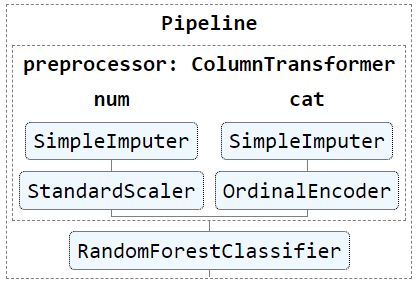


The pipeline is divided into two main components: *preprocessing* and *modeling*. As we can see, the preprocessing applies operations separately to the numerical (num) features and to the categorical (cat) features. Next, we will replicate this preprocessor to solve our dataset issues.

---
### Creating a preprocessing pipeline

For the preprocessing we need to apply imputation to both the categorical and numerical features. In addition, the categorical features need to be encoded and it is good practice to normalize numerical features. Hence, we need to split the preprocessing pipeline into two branches: *numerical* and *categorical*. Let's define them both.

In [6]:
# Pipeline object that we introduced above
from sklearn.pipeline import Pipeline 
# Imputation Transformer
from sklearn.impute import SimpleImputer
# Encoding Transformers
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Defining the categorical pipeline
#   steps of the pipeline have the form: ('name', TransformerObject)
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories='auto'))               
])

# Defining the numerical pipeline
numerical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('normalizer', StandardScaler())                                        
])

Let's have a look at what we created (it is interactive HTML!):

In [7]:
from sklearn import set_config
set_config(display='diagram')

categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder())])

In [8]:
numerical_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('normalizer', StandardScaler())])

Now that we have created the preprocessing for the categorical and numerical features, we need to combine them into one. This can be done using the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) which is a component that can apply different transformations to different columns of the DataFrame.

In [9]:
from sklearn.compose import ColumnTransformer

preprocessing_pipe = ColumnTransformer(
    transformers=[
      # ('name', Transformer, [column names])
        ('num', numerical_pipe, numerical_features),
        ('cat', categorical_pipe, categorical_features)]
)

preprocessing_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('normalizer',
                                                  StandardScaler())]),
                                 ['Age', 'Fare', 'Pclass']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

A perfect match! Now to double check that indeed the preprocessing works, we call the fit_transform operation on the train data:

In [10]:
# You can see what the preprocessing pipeline does does if you execute the following code
X_train_transformed = preprocessing_pipe.fit_transform(X_train)
pd.DataFrame(X_train_transformed).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       623 non-null    float64
 1   1       623 non-null    float64
 2   2       623 non-null    float64
 3   3       623 non-null    float64
 4   4       623 non-null    float64
dtypes: float64(5)
memory usage: 24.5 KB


All features are nicely imputed and are now of a numerical type. Let's add a prediction model on top of this!

## 3. Adding a scikit-learn model

To do actual predictions using our features we need to add a model on top of the transformations. In this case we will add a simple `RandomForestClassifier`.



In [11]:
from sklearn.ensemble import RandomForestClassifier

full_pipe = Pipeline(steps=[
    ('preprocessor', preprocessing_pipe),
    ('clf', RandomForestClassifier(n_estimators=20, random_state=42))
])

full_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=20, random_state=42))])

Now we can train our full pipeline, like you would a normal model, and assess the the accuracy. Note that the `X_train` *fitted* preprocessing is applied to `X_test` too.

In [12]:
model = full_pipe.fit(X_train, y_train)

print(f'Train accuracy: {model.score(X_train, y_train):.2f}')
print(f'Test accuracy: {model.score(X_test, y_test):.2f}')

Train accuracy: 0.97
Test accuracy: 0.79


Actually our accuracy is pretty okay given the features that we have. However, 
let's assume we were dealing with a more complicated dataset and we wanted to squeeze out the last bits of performance, what to do? 

Given that we already tried a tree based model (bag of trees) on our dataset a logical next step would be a Gradient Boosting Tree model. In a recent comparison of ours, we found that the LightGBM model delivers the best performance/cpu time, so let's give that one a shot.

## 4. Move to LightGBM

Luckily for us (almost) all major structured data models in the ML space have a `scikit-learn` compatible API. From the `lightgbm` package we can simpy import the `LGBMClassifier` and substitute it for any `scikit-learn` classifier. The same holds true for the `LGBMRegressor`. 

In [13]:
from lightgbm import LGBMClassifier

full_pipe = Pipeline(steps=[
    ('preprocessor', preprocessing_pipe),
    ('clf', LGBMClassifier(n_estimators=20, random_state=42))
])

full_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked'])])),
                ('clf', LGBMClassifier(n_estimators=20, random_state=42))])

In [14]:
model = full_pipe.fit(X_train, y_train)

print(f'Train accuracy: {model.score(X_train, y_train):.2f}')
print(f'Test accuracy: {model.score(X_test, y_test):.2f}')

Train accuracy: 0.86
Test accuracy: 0.80


Not the performance gain you may have hoped for, as the dataset is too 'simple'. But not to worry, you will encounter more challenging situations in the field. And when you do, now you know how easy it is to get started on the latest Gradient Boosting Trees using scikit learn best practices.

For the interested reader, we have added a section on hyper parameter tuning on the pipeline object. Make sure to check it out below!



# In summary

You have been introduced to the `scikit-learn` [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object. This object chains preprocessing and modeling together for easy execution and hyper parameter tuning (see the bonus content). In addition, you have seen how you can easily combine scikit-learn with the latest GBMs to kickstart your next project.

---

## Bonus Content



### 5. Hyper parameter tuning

Just building a model isn't all, you also need to find the right parameters for the model! This is important especially for gradient boosting as they are [very sensitive to hyper parameters](https://bradleyboehmke.github.io/HOML/gbm.html#tuning-strategy).

In the next block we show how to build up the hyper parameter space, *including* tuning for the preprocessing.

#### Defining the search space

In [15]:
# Import random sampling methods to more efficiently sample the hp search space
from scipy.stats import uniform, randint
from sklearn.utils.fixes import loguniform

# Search space for the model
search_space = {
        'n_estimators': randint(low=50, high=500),  # Boosting steps
        'boosting_type': ['gbdt', 'dart', 'goss'],  # See LightGBM docs
        'max_depth': randint(low=3, high=9),  # Depth of the DTs
        'num_leaves': [int(2**9)],  # Only restrict by depth
        'learning_rate': loguniform(1e-4, 1),  # Sample on a log scale
        'reg_alpha': uniform(loc=0.0, scale=2.0),  # Regularization
        'reg_lambda': uniform(loc=0.0, scale=2.0),  # Regularization
}
# Add prefix to indicate to which part of the pipeline the search space belongs
search_space = {'clf__' + key: value for key, value in search_space.items()}

# Paramter tuning for the numerical impute strategy
search_space.update({'preprocessor__num__imputer__strategy': ['mean', 'median'],})

#### Setting the validation set strategy

In addition to defining the search space, we also need to come up with a validation strategy. Typically a model is trained on various train and validation sets. The HPs are judged based on the score on the various validation sets. Here we will go for shuffle split, which is graphically explained below:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_006.png)

Many other strategies exist, for which we refer to the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py).

In [16]:
from sklearn.model_selection import ShuffleSplit

cross_validator = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

#### Randomized grid search

We now have all the ingredients to apply hyperparameter tuning to our pipeline. We choose for *Randomized* grid search, which is more efficient than regular grid search in sampling the space. For more background please visit [scikit-learn grid search](https://scikit-learn.org/stable/modules/grid_search.html).

In [17]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(estimator=full_pipe,
                            cv=cross_validator,
                            param_distributions=search_space,
                            verbose=1,
                            refit=True,  # After having found the best HPs refit to the whole set
                            random_state=42,
                            n_jobs=-1)  # Parallel <3

search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.1, train_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('normalizer',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'Pclass']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'...
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7777461a90>,
                                        'clf__num_leaves': [512],
                                        'clf__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f777746a0d0>,
                                        'clf__reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f777746a340>,
                                        'preprocessor__num__imputer__strategy': ['mean',
                                                                                 'median']},
                   random_state=42, verbose=1)

In [18]:
# Extract the best pipeline
best_model = search.best_estimator_

print(f'Train accuracy: {model.score(X_train, y_train):.2f}')
print(f'Test accuracy: {model.score(X_test, y_test):.2f}')

Train accuracy: 0.86
Test accuracy: 0.80


# 6. Model and Instance Explainability

A big plus of using Tree based models is that they are so called 'white-box' models i.e. decisions can be followed. Typically, these models have built-in features to display the 'feature importance', a number indicating how important a certain feature is for modeling decisions. Below is an example for LightGBM:

Column mapping:
[(0, 'Pclass'), (1, 'Sex'), (2, 'Age'), (3, 'Fare'), (4, 'Embarked')]


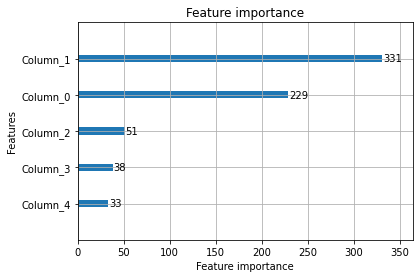

In [19]:
from lightgbm import plot_importance

plot_importance(best_model[1])

print('Column mapping:')
print(list(zip(range(5), X_train.columns)))

If you want to go a step further and not only explain global model behavior, but go up to the instance / individual sample level we advice you to have a look at [SHAP](https://github.com/slundberg/shap). And stay tuned, as in the future we will probably take a deep dive into that library.